[View in Colaboratory](https://colab.research.google.com/github/jhamanisha/ProgrammingAssignment2/blob/master/Project_1_Text_Similarity.ipynb)

# **Imports**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from keras.utils.data_utils import get_file

import tensorflow as tf
import numpy as np # linear algebra
import random
import sys
import io
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
print(tf.keras.__version__)
print(tf.__version__)

2.1.6-tf
1.10.1


In [3]:
!ls
!

gdrive.py   sample_data  urls.txt    wget-log.3  wget-log.7  x_train.txt
labels.csv  sutils.py	 wget-log    wget-log.4  wget-log.8  y_test.txt
__MACOSX    test.csv	 wget-log.1  wget-log.5  wget-log.9  y_train.txt
README.txt  train.csv	 wget-log.2  wget-log.6  x_test.txt


In [0]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt

# Load Dataset

In [5]:

!wget -qq  https://www.dropbox.com/s/lnp4bn4wm3lhie1/utils.zip
!wget https://www.dropbox.com/s/rtjelse713xwzjj/text-similarity.zip 
#!wget https://www.dropbox.com/s/65qpj88viuboeeo/wili-2018.zip
  
!unzip -qq utils.zip
!rm utils.zip

!unzip -qq text-similarity.zip
!rm text-similarity.zip

#!unzip -qq wili-2018.zip
#!rm wili-2018.zip

!ls


Redirecting output to ‘wget-log.10’.

Redirecting output to ‘wget-log.11’.
replace gdrive.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/._gdrive.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace sutils.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/._sutils.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
gdrive.py    sutils.py	wget-log.1   wget-log.4  wget-log.9
labels.csv   test.csv	wget-log.10  wget-log.5  x_test.txt
__MACOSX     train.csv	wget-log.11  wget-log.6  x_train.txt
README.txt   urls.txt	wget-log.2   wget-log.7  y_test.txt
sample_data  wget-log	wget-log.3   wget-log.8  y_train.txt


In [6]:
df_train = pd.read_csv('train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('test.csv', encoding="ISO-8859-1")

#df_train = pd.read_fwf('y_train.txt', encoding="ISO-8859-1")
#df_test = pd.read_fwf('y_test.txt', encoding="ISO-8859-1")

df_train = df_train.rename(columns = {'Unnamed: 0':'train_id'})

print('df_train:', df_train.shape)
display(df_train.head(5))

print('df_test:', df_test.shape)
display(df_test.head(5))

df_train: (2142, 6)


,train_id,description_x,description_y,ticker_x,ticker_y,same_security
0,0,first trust dow jones internet,first trust dj internet idx,FDN,FDN,True
1,1,schwab intl large company index etf,schwab strategic tr fundamental intl large co ...,FNDF,FNDF,True
2,2,vanguard small cap index adm,vanguard small-cap index fund inst,VSMAX,VSCIX,False
3,3,duke energy corp new com new isin #us4 sedol #...,duke energy corp new com new isin #us26441c204...,DUK,DUK,True
4,4,visa inc class a,visa inc.,V,V,True


df_test: (516, 4)


,test_id,description_x,description_y,same_security
0,0,semtech corp,semtech corporation,NaN
1,1,vanguard mid cap index,vanguard midcap index - a,NaN
2,2,spdr gold trust gold shares,spdr gold trust spdr gold shares,NaN
3,3,vanguard total bond index adm,vanguard total bond market index,NaN
4,4,oakmark international fund class i,oakmark international cl i,NaN


## Function for visualize result

In [0]:
def cal_correct(df_temp, col, threshold):
    df_temp[col + '_predicted'] = df_temp[col] >= threshold
    df_temp[col + '_correct'] = df_temp[col + '_predicted'] == df_result['same_security']
    
    df_group = df_temp.groupby(df_temp[col + '_correct']).size().reset_index()
    df_group.columns = ['correct', 'cnt']

    plt.pie(df_group['cnt'].tolist(), labels=df_group['correct'].tolist(), autopct='%1.1f%%')
    plt.show()    

In [0]:
thresholds = [0.4, 0.5, 0.6]

## Using Cosine Similarity to `check` whether it is same security

In [0]:
#import re
#from sklearn.feature_extraction import text
#vectorizer = text.TfidfVectorizer()

#def cosine_sim(test1, test2):
 #   tfidf = vectorizer.fit_transform([test1, test2])
  #  result = ((tfidf * tfidf.T).A)[0,1]
   # return result
    
#def cosine_sim_df(df_data):
 #   col1 = 'description_x'
  #  col2 = 'description_y'
  #  df_data[col1] = df_data[col1].str.replace(r'\d', '')
  #  df_data[col2] = df_data[col2].str.replace(r'\d', '')
    
  #  df_data['cos_sim'] = 0
  #  df_data['cos_sim'] = df_data.apply(
  #      lambda x: cosine_sim(x[col1], x[col2]), axis=1)
  #  return df_data

,train_id,description_x,description_y,ticker_x,ticker_y,same_security,cos_sim,cos_sim_predicted,cos_sim_correct
0,0,first trust dow jones internet,first trust dj internet idx,FDN,FDN,True,0.431613,False,False
1,1,schwab intl large company index etf,schwab strategic tr fundamental intl large co ...,FNDF,FNDF,True,0.527072,False,False
2,2,vanguard small cap index adm,vanguard small-cap index fund inst,VSMAX,VSCIX,False,0.580333,False,True
3,3,duke energy corp new com new isin #us sedol #b...,duke energy corp new com new isin #usc sedol #...,DUK,DUK,True,0.716812,True,True
4,4,visa inc class a,visa inc.,V,V,True,0.709297,True,True


threshold: 0.4


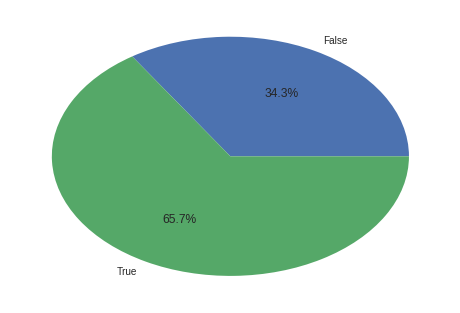

threshold: 0.5


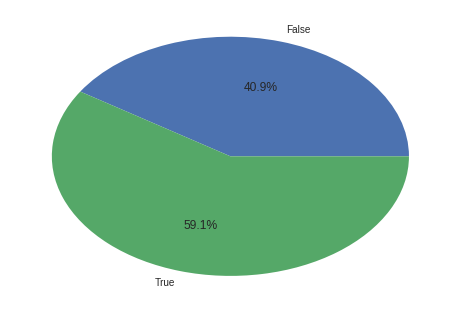

threshold: 0.6


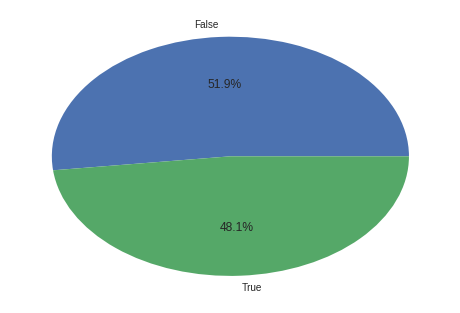

In [11]:
#df_result = cosine_sim_df(df_train)
#display(df_result.head(5))

#for x in thresholds:
 #   print('threshold:', x)
  #  cal_correct(df_result, 'cos_sim', x)

In [12]:
#axis('equal')
#pie(sums, labels=sums.index)
#show()

NameError: ignored

## Using SequenceMatcher to `check` whether it is same security

In [0]:
from difflib import SequenceMatcher

def seq_match(test1, test2):
    return SequenceMatcher(None, test1, test2).ratio()
    
def seq_match_df(df_data):
    col1 = 'description_x'
    col2 = 'description_y'
    df_data[col1] = df_data[col1].str.replace(r'\d', '')
    df_data[col2] = df_data[col2].str.replace(r'\d', '')
    
    df_data['seq_match'] = 0
    df_data['seq_match'] = df_data.apply(
        lambda x: seq_match(x[col1], x[col2]), axis=1)
    
    return df_data

,train_id,description_x,description_y,ticker_x,ticker_y,same_security,seq_match
0,0,first trust dow jones internet,first trust dj internet idx,FDN,FDN,True,0.807018
1,1,schwab intl large company index etf,schwab strategic tr fundamental intl large co ...,FNDF,FNDF,True,0.666667
2,2,vanguard small cap index adm,vanguard small-cap index fund inst,VSMAX,VSCIX,False,0.806452
3,3,duke energy corp new com new isin #us sedol #b...,duke energy corp new com new isin #usc sedol #...,DUK,DUK,True,0.980000
4,4,visa inc class a,visa inc.,V,V,True,0.640000


threshold: 0.4


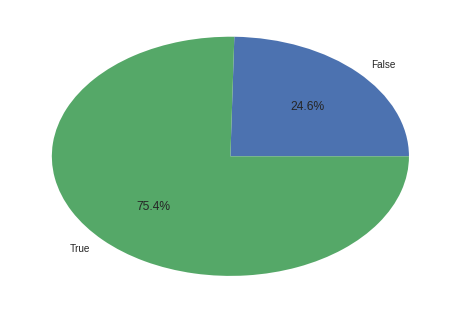

threshold: 0.5


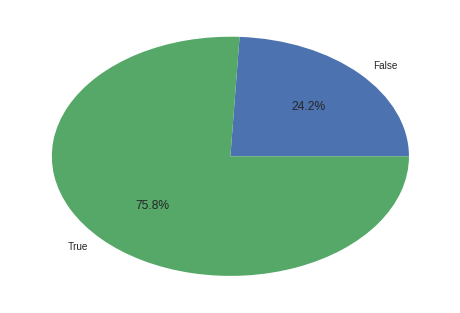

threshold: 0.6


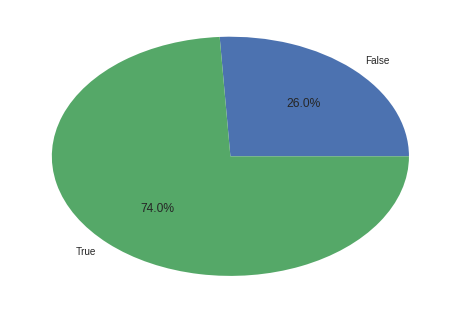

In [10]:
df_result = seq_match_df(df_train)
display(df_result.head(5))

for x in thresholds:
    print('threshold:', x)
    cal_correct(df_result, 'seq_match', x)

# **classification engine**

,test_id,description_x,description_y,same_security,seq_match
0,0,semtech corp,semtech corporation,NaN,0.774194
1,1,vanguard mid cap index,vanguard midcap index - a,NaN,0.893617
2,2,spdr gold trust gold shares,spdr gold trust spdr gold shares,NaN,0.915254
3,3,vanguard total bond index adm,vanguard total bond market index,NaN,0.819672
4,4,oakmark international fund class i,oakmark international cl i,NaN,0.866667


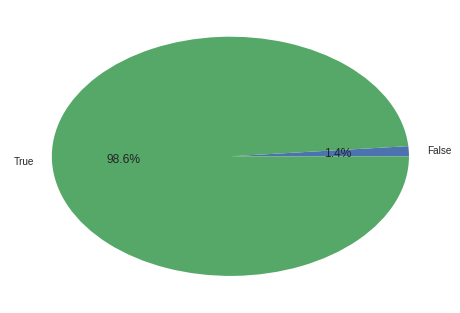

In [11]:
df_result = seq_match_df(df_test )
display(df_result.head(5))

df_result['same_security'] = df_result['seq_match'] > 0.5    
df_group = df_result.groupby('same_security').size().reset_index()
df_group.columns = ['correct', 'cnt']

plt.pie(df_group['cnt'].tolist(), labels=df_group['correct'].tolist(), autopct='%1.1f%%')
plt.show()    